In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
import pennylane as qml
from pennylane import numpy
from scipy.optimize import minimize
import csv


In [33]:
df = pd.read_csv('/Users/edoardozappia/Downloads/creditcard.csv')

In [34]:
print(len(df['Amount']))

284807


In [35]:
df['V29']=np.zeros((len(df['Amount']), 1))
df['V30']=np.zeros((len(df['Amount']), 1))
df['V31']=np.zeros((len(df['Amount']), 1))

In [36]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,V29,V30,V31
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0,0.0


In [37]:
df['Amount'] = np.log10(df.Amount + 0.00001)

In [38]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,V29,V30,V31
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.174990,0,0.0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.429754,0,0.0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.578249,0,0.0,0.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.091667,0,0.0,0.0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,1.845036,0,0.0,0.0,0.0


In [39]:
# Split
fraud = df[df['Class'] == 1]
clean = df[df['Class'] == 0]

In [40]:
# Shuffle
clean = clean.sample(frac=1).reset_index(drop=True)

In [41]:
# training set: exlusively non-fraud transactions
X_train = clean.iloc[:50].drop('Class', axis=1)

In [42]:
print(len(X_train['V1']))

50


In [43]:
# testing  set: the remaining non-fraud + all the fraud 
fraud_test = fraud[:20]

# Concatenazione dei dati non fraudolenti e fraudolenti
X_test = pd.concat([clean.iloc[50:80], fraud_test]).sample(frac=1).reset_index(drop=True)

X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,V29,V30,V31
0,91789.0,-0.317822,0.475162,1.396991,0.141650,0.040801,0.539120,-0.135772,0.206730,1.693994,...,0.659504,-0.668153,-0.212406,0.090926,0.194625,1.298853,0,0.0,0.0,0.0
1,143421.0,-0.142922,1.125461,-0.438516,-0.675390,0.842967,-0.620282,0.840295,0.055664,-0.079265,...,0.648179,-0.422195,0.093237,0.326405,0.131968,0.357937,0,0.0,0.0,0.0
2,20478.0,-0.534639,0.462400,2.614235,1.118064,-0.596837,1.599259,1.436459,-0.510462,2.145376,...,0.179379,-0.590695,-0.791150,-0.433968,-0.588619,2.291968,0,0.0,0.0,0.0
3,7891.0,-1.585505,3.261585,-4.137422,2.357096,-1.405043,-1.879437,-3.513687,1.515607,-1.207166,...,-0.425550,0.123644,0.321985,0.264028,0.132817,0.000004,1,0.0,0.0,0.0
4,8415.0,-0.251471,4.313523,-6.891438,6.796797,0.616297,-2.966327,-2.436653,0.489328,-3.371639,...,-0.263743,1.539916,0.523574,0.891025,0.572741,0.000004,1,0.0,0.0,0.0


In [44]:
print(f"""Our testing set is composed as follows:

{X_test.Class.value_counts()}""")

Our testing set is composed as follows:

Class
0    30
1    20
Name: count, dtype: int64


In [45]:
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [46]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

In [47]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
print(X_train_transformed)

[[0.9890711  0.73821258 0.44989449 ... 0.         0.         0.        ]
 [0.99981555 0.89459228 0.45712249 ... 0.         0.         0.        ]
 [0.99904412 0.75585127 0.51150738 ... 0.         0.         0.        ]
 ...
 [0.79961373 0.         0.88109987 ... 0.         0.         0.        ]
 [0.9509112  0.6208997  0.         ... 0.         0.         0.        ]
 [0.98952991 0.60718621 0.29784893 ... 0.         0.         0.        ]]


In [48]:
def ansatz_custom_digits(params, n_wires_latent, n_wires_trash):
    params = qml.numpy.tensor(params, requires_grad=True)
    for j in range(6):
        for i in range(n_wires_latent+n_wires_trash):
            k = j*5+i
            qml.RY(params[k], wires=i)
        if j!=4:
            for i in range(n_wires_latent + n_wires_trash - 1):
                qml.CNOT(wires=[i, i+1])

In [49]:
dev = qml.device('default.qubit', wires=8)
@qml.qnode(dev)
def train_circuit(params, image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    ansatz_custom_digits(image, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(params, n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)

In [50]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [51]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [52]:
params = np.random.random((30,))
params = qml.numpy.tensor(params, requires_grad=True)

(<Figure size 4000x900 with 1 Axes>, <Axes: >)


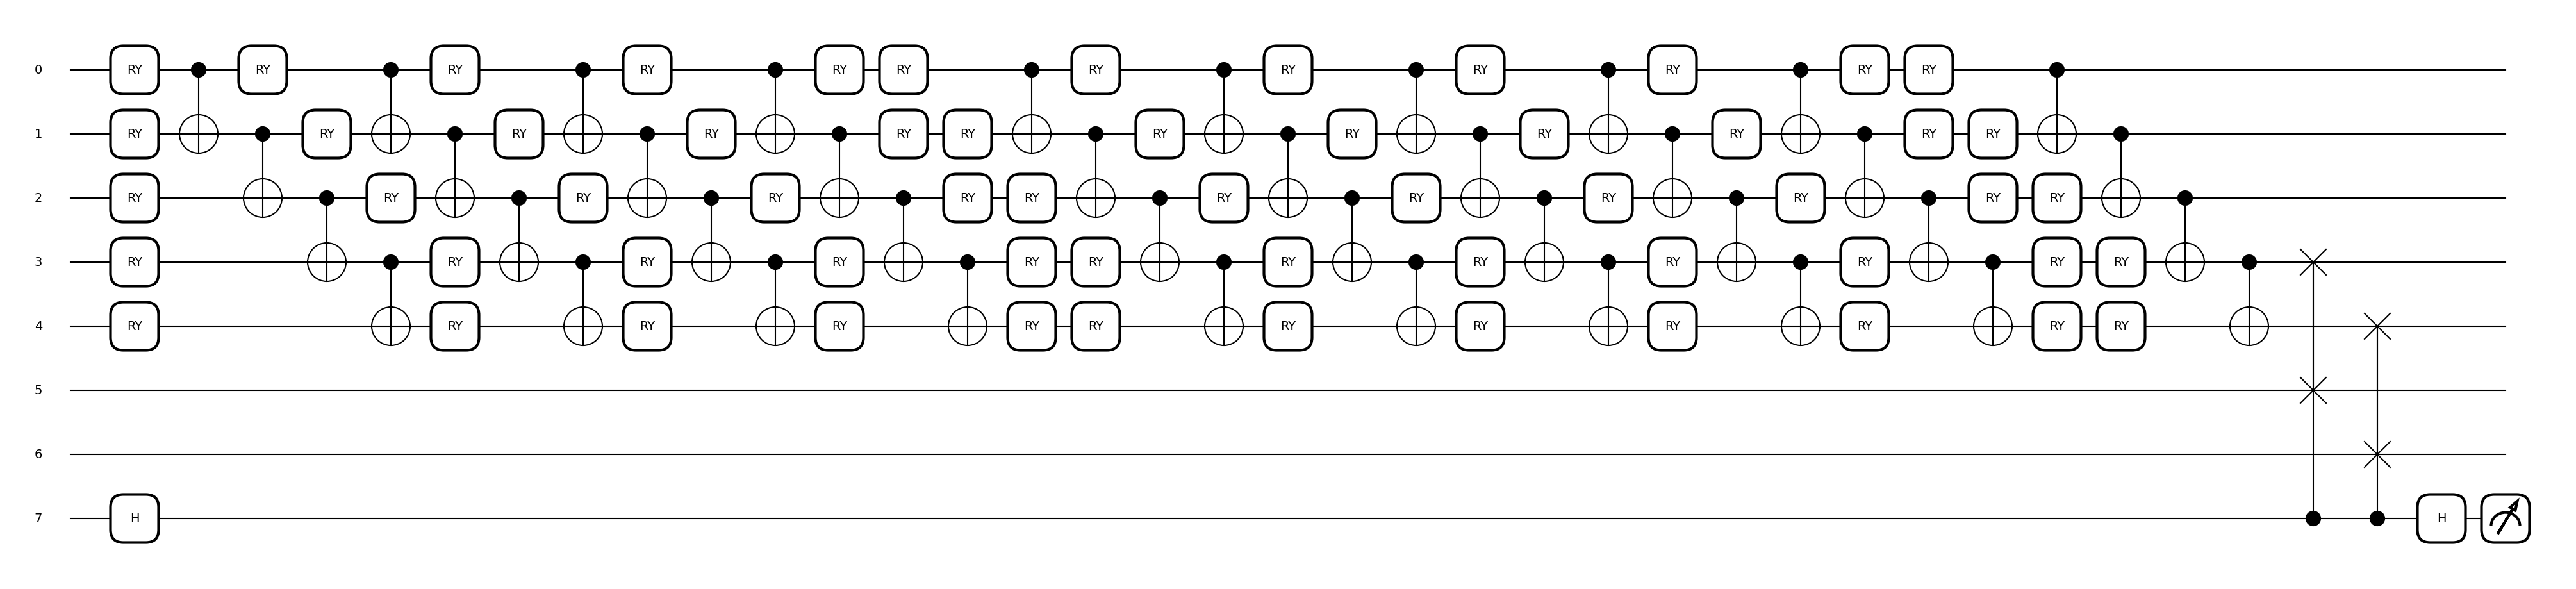

In [53]:
drawer = qml.draw_mpl(train_circuit)
print(drawer(params, X_train_transformed[0]))

In [54]:
def cost_function(weights):
    probabilities = [train_circuit(weights, transaction) for transaction in X_train_transformed]
    print(probabilities)
    cost_value = np.sum([p[1] for p in probabilities])/X_train_transformed.shape[0]
    return cost_value

In [55]:
cost_values = []
opt_weights = []
def callback(xk):
    cost_val = cost_function(xk)
    cost_values.append(cost_val)
    opt_weights.append(xk)
    print(f"Step {len(cost_values)}: cost = {cost_val:.4f}, params = {xk}")

In [56]:
minimize(cost_function, params, method='COBYLA', callback=callback, options={'maxiter': 500})
opt_weights = opt_weights[-1]

[tensor([0.57959525, 0.42040475], requires_grad=True), tensor([0.56338821, 0.43661179], requires_grad=True), tensor([0.57972326, 0.42027674], requires_grad=True), tensor([0.57926958, 0.42073042], requires_grad=True), tensor([0.56485845, 0.43514155], requires_grad=True), tensor([0.57105539, 0.42894461], requires_grad=True), tensor([0.57032157, 0.42967843], requires_grad=True), tensor([0.55600454, 0.44399546], requires_grad=True), tensor([0.55942688, 0.44057312], requires_grad=True), tensor([0.56528694, 0.43471306], requires_grad=True), tensor([0.56530477, 0.43469523], requires_grad=True), tensor([0.5577913, 0.4422087], requires_grad=True), tensor([0.5680443, 0.4319557], requires_grad=True), tensor([0.5705799, 0.4294201], requires_grad=True), tensor([0.56887539, 0.43112461], requires_grad=True), tensor([0.56427996, 0.43572004], requires_grad=True), tensor([0.5658548, 0.4341452], requires_grad=True), tensor([0.56479236, 0.43520764], requires_grad=True), tensor([0.56432366, 0.43567634], re

In [57]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights_quantum_anomaly_det.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in opt_weights])

In [58]:
print(cost_values[-1])

0.031164212178677934


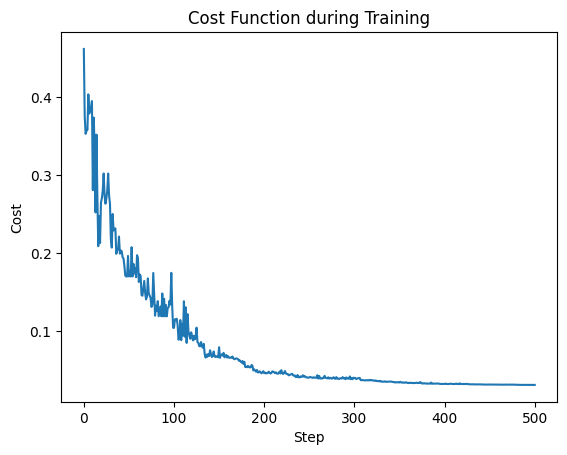

In [59]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(cost_values)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [60]:
# Reset the qubits indicated by wir to zero
def reset_to_zero(wir):
    m1 = qml.measure(wir[0])
    m2 = qml.measure(wir[1])
    qml.cond(m1, qml.PauliX)(wir[0])
    qml.cond(m2, qml.PauliX)(wir[1])

In [61]:
@qml.qnode(dev)
def autoencoder(opt_weights, transaction):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    ansatz_custom_digits(transaction, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(opt_weights, n_wires_latent, n_wires_trash)
    reset_to_zero([3, 4])
    qml.adjoint(ansatz_custom_digits)(opt_weights, n_wires_latent, n_wires_trash)
    #return [qml.expval(qml.PauliZ(i)) for i in range(5)]
    return qml.density_matrix(wires=[0, 1, 2, 3, 4])

(<Figure size 5900x700 with 1 Axes>, <Axes: >)


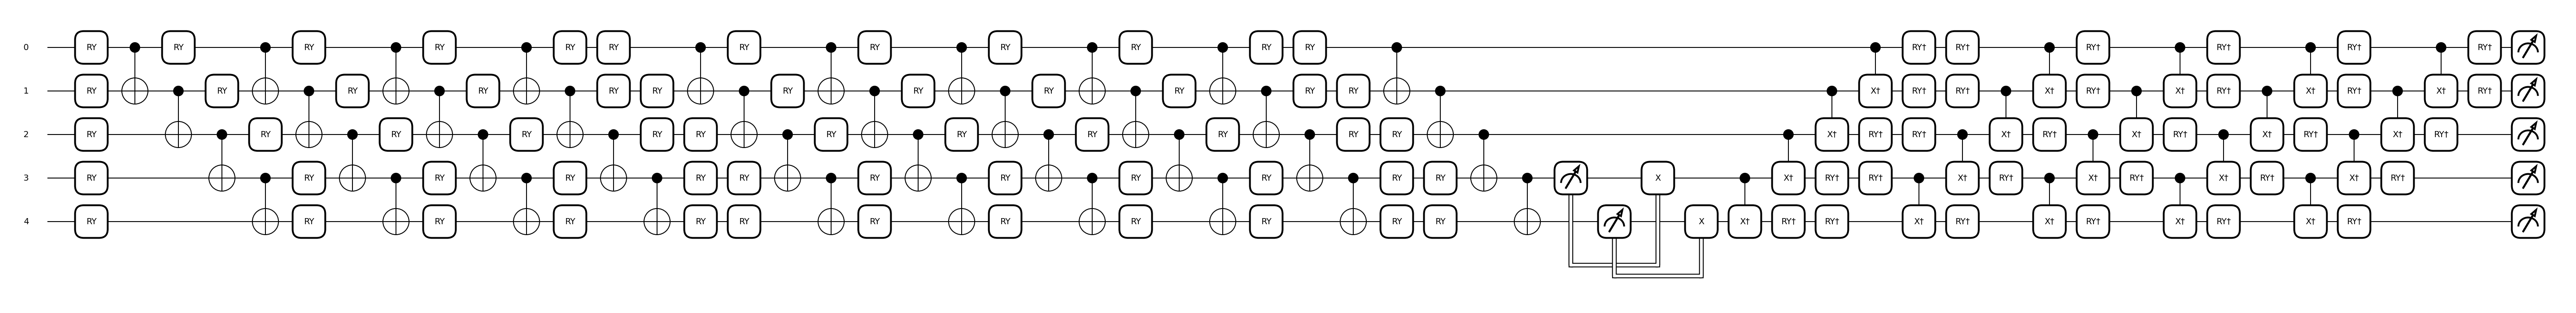

In [62]:
drawer_2 = qml.draw_mpl(autoencoder)
print(drawer_2(opt_weights, X_train_transformed[0]))